This code was heavily based on Enge et al. 2021 codes available at https://osf.io/34ry2/ (we are highly grateful for their commitment to open research)

In [1]:
import random
from glob import glob
from math import sqrt
from os import makedirs, path
from re import sub
from shutil import copy
from sys import argv

import numpy as np
import pandas as pd
from nibabel import save
from nilearn import image, reporting
from nimare import correct, io, meta, utils
from scipy.stats import norm


In [2]:
# Define function to generate a new data set with k null studies added
def generate_null(
    text_file="peaks.txt",
    space="ale_2mm",
    k_null=100,
    random_seed=None,
    output_dir="./",
):

    # Load NiMARE's gray matter template
    # comment：这里直接用brain是可以的吗？还是要去找一个明确说明是gray matter的模板？
    # brain:tpl-MNI152NLin6Asym_res-01_desc-brain_mask.nii.gz
    temp = utils.get_template(space=space, mask="brain")

    # Extract possible MNI coordinates for all gray matter voxels
    x, y, z = np.where(temp.get_fdata() == 1.0)
    within_mni = image.coord_transform(x=x, y=y, z=z, affine=temp.affine)
    within_mni = np.array(within_mni).transpose()

    # Read the original Sleuth file into a NiMARE data set
    dset = io.convert_sleuth_to_dataset(text_file, target=space)

    # Set a random seed to make the results reproducible
    if random_seed:
        random.seed(random_seed)

    # Resample numbers of subjects per experiment based on the original data
    nr_subjects_dset = [n[0] for n in dset.metadata["sample_sizes"]]
    nr_subjects_null = random.choices(nr_subjects_dset, k=k_null)

    # Resample numbers of peaks per experiment based on the original data
    nr_peaks_dset = dset.coordinates["study_id"].value_counts().tolist()
    nr_peaks_null = random.choices(nr_peaks_dset, k=k_null)

    # Create random peak coordinates
    idx_list = [
        random.sample(range(len(within_mni)), k=k_peaks) for k_peaks in nr_peaks_null
    ]
    peaks_null = [within_mni[idx] for idx in idx_list]

    # Copy original experiments to the destination Sleuth file
    makedirs(output_dir, exist_ok=True)
    text_file_basename = path.basename(text_file)
    null_file_basename = sub(
        pattern=".txt", repl="_plus_k" + str(k_null) + ".txt", string=text_file_basename
    )
    null_file = output_dir + "/" + null_file_basename
    copy(text_file, null_file)

    # Append all the null studies to the Sleuth file
    f = open(null_file, mode="a")
    for i in range(k_null):
        f.write(
            "\n// nullstudy"
            + str(i + 1)
            + "\n// Subjects="
            + str(nr_subjects_null[i])
            + "\n"
        )
        np.savetxt(f, peaks_null[i], fmt="%.3f", delimiter="\t")
    f.close()

    # Read the new Sleuth file and return it as a NiMARE data set
    dset_null = io.convert_sleuth_to_dataset(null_file, target=space)
    return dset_null


In [4]:
# Define function to compute the FSN for all voxels from a Sleuth file
def compute_fsn(
    text_file="peaks.txt",
    space="ale_2mm",
    voxel_thresh=0.001,
    cluster_thresh=0.05,
    n_iters=1000,
    k_max_factor=5,
    random_ale_seed=None,
    random_null_seed=None,
    output_dir="./",
):

    # Let's show the user what we are doing
    print("\nCOMPUTING FSN FOR " + text_file + " (seed: " + str(random_null_seed) + ")")

    # Set random seed for original ALE if requested
    if random_ale_seed:
        np.random.seed(random_ale_seed)

    # Recreate the original ALE analysis
    ale = meta.cbma.ALE()
    corr = correct.FWECorrector(
        method="montecarlo", voxel_thresh=voxel_thresh, n_iters=n_iters
    )
    dset_orig = io.convert_sleuth_to_dataset(text_file=text_file, target=space)
    res_orig = ale.fit(dset_orig)
    cres_orig = corr.transform(res_orig)

    # Extract the original study IDs
    ids_orig = dset_orig.ids.tolist()

    # Create a new data set with a large number null studies added
    k_max = len(ids_orig) * k_max_factor
    dset_null = generate_null(
        text_file=text_file,
        space=space,
        k_null=k_max,
        random_seed=random_null_seed,
        output_dir=output_dir,
    )

    # Create thresholded cluster mask
    img_fsn = cres_orig.get_map("z_desc-size_level-cluster_corr-FWE_method-montecarlo")
    cluster_thresh_z = norm.ppf(1 - cluster_thresh / 2)
    img_fsn = image.threshold_img(img_fsn, threshold=cluster_thresh_z)
    img_fsn = image.math_img("np.where(img > 0, 1, 0)", img=img_fsn)

    # Create cluster-thresholded z map
    img_z = cres_orig.get_map("z")
    img_z = image.math_img("img1 * img2", img1=img_fsn, img2=img_z)

    # Iteratively add null studies up to our pre-defined maximum
    for k in range(1, k_max):

        # Print message
        print("Computing ALE for k = " + str(k) + " null studies added...")

        # Create a new data set with k null studies added
        ids_null = ["nullstudy" + str(x) + "-" for x in range(1, k + 1)]
        ids = ids_orig + ids_null
        dset_k = dset_null.slice(ids)

        # Compute the ALE
        res_k = res = ale.fit(dset_k)
        cres_k = corr.transform(result=res_k)

        # Create a thresholded cluster mask
        img_k = cres_k.get_map("z_desc-size_level-cluster_corr-FWE_method-montecarlo")
        img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
        img_k = image.math_img("np.where(img > 0, 1, 0)", img=img_k)

        # Use this to update the per-voxel FSN - this is a bit hack-ish: On a voxel-by-
        # voxel basis, we increase the value by 1 if and only if the voxel has remained
        # significant. As soon as it has failed to reach significance once, we never
        # increase FSN any further. This is handeled by comparing the current FSN to
        # the current value of k.
        count = str(k + 1)
        formula = "np.where(img_fsn + img_k == " + count + ", img_fsn + 1, img_fsn)"
        img_fsn = image.math_img(formula, img_fsn=img_fsn, img_k=img_k)

        # Quit as soon as there are no significant clusters left in the current map
        if not np.any(img_k.get_fdata()):
            print("No more significant voxels - terminating\n")
            break

    # Save the FSN map that we've created in the loop
    filename_img = path.basename(text_file).replace(".txt", "_fsn.nii.gz")
    save(img_fsn, filename=output_dir + "/" + filename_img)

    # Extract the FSN values at the original cluster peaks
    tab_fsn = reporting.get_clusters_table(img_z, stat_threshold=0, min_distance=1000)
    inv_affine = np.linalg.inv(img_z.affine)
    x, y, z = [np.array(tab_fsn[col]) for col in ["X", "Y", "Z"]]
    x, y, z = image.coord_transform(x=x, y=y, z=z, affine=inv_affine)
    x, y, z = [arr.astype("int") for arr in [x, y, z]]
    tab_fsn["FSN"] = img_fsn.get_fdata()[x, y, z]

    # Save this cluster table with the new FSN column
    filename_tab = path.basename(text_file).replace(".txt", "_fsn.tsv")
    tab_fsn.to_csv(output_dir + "/" + filename_tab, sep="\t", index=False)

    return img_fsn, tab_fsn



In [4]:
# Ideally, we want to perform all of this multiple times for different (random) filedrawers. Otherwise, the resulting FSN values would hinge a lot on the random patterns of these specific null experiments. However, doing all of these iterative simulations multiple times is extremly computationally expensive. We therefore wrote the next bit of the notebook in a way so that it can be run in parallel on our high performance computing (HPC) cluster. For this, we would call this notebook as a Python script from the command line and need to provide it with two additional parameters: The name of the original ALE analysis for which we want to compute the FSN and the number of different filedrawers we want to estimate (so we can always compute multiple filedrawers in parallel). If you don't happen to have access to an HPC and want to try the out the simulations directly withing the notebook, simply uncomment the two lines of code to define `prefixes` and `nr_filedrawers` locally.
# Get which FSN analyses to perform from the command line
prefixes = ["hypoactivation"] 

# Get number of filedrawers per analysis from the command line
nr_filedrawers = 5


In [5]:

# # Or define them here for debugging
# prefixes = ["all", "knowledge", "relatedness", "objects"]
# nr_filedrawers = 10

# List the filenames of the Sleuth text files
text_files = ["../1_Data/AnalysisData/InputData_ALE/hypoactivation.txt"]


In [6]:

# Create output directory names
output_dirs = ["../3_Output/7_FSN/" + prefix + "/" for prefix in prefixes]


In [7]:

# Create random seeds for filedrawers
random_null_seeds = random.sample(range(1000), k=nr_filedrawers)
filedrawers = ["filedrawer" + str(seed) for seed in random_null_seeds]


In [8]:

# Use our function to compute multiple filedrawers for each text file
_ = [
    [
        compute_fsn(
            text_file=text_file,
            space="ale_2mm",
            voxel_thresh=0.001,
            cluster_thresh=0.05,
            n_iters=100,
            k_max_factor=5,
            random_ale_seed=2025,
            random_null_seed=random_null_seed,
            output_dir=output_dir + filedrawer,
        )
        for random_null_seed, filedrawer in zip(random_null_seeds, filedrawers)
    ]
    for text_file, output_dir in zip(text_files, output_dirs)
]


# Compute mean FSN across filedrawers
for prefix in prefixes:

    # Read FSN maps from all filedrawers
    fnames_maps = glob(
        "../3_Output/7_FSN/" + prefix + "/filedrawer*/" + prefix + "_fsn.nii.gz"
    )
    imgs_fsn = [image.load_img(fname) for fname in fnames_maps]

    # Average and save
    img_mean = image.mean_img(imgs_fsn)
    fname_img_mean = "../3_Output/7_FSN/" + prefix + "/" + prefix + "_mean_fsn.nii.gz"
    save(img_mean, fname_img_mean)

    # Read FSN tables from all filedrawers
    fnames_tabs = glob(
        "../3_Output/7_FSN/" + prefix + "/filedrawer*/" + prefix + "_fsn.tsv"
    )
    tabs_fsn = [pd.read_csv(fname, delimiter="\t") for fname in fnames_tabs]
    tab_fsn = pd.concat(tabs_fsn)

    # Compute summary statistics
    agg = tab_fsn.groupby("Cluster ID")["FSN"].agg(["mean", "count", "std"])

    # Compute confidence intervals
    ci_level = 0.05
    z_crit = abs(norm.ppf(ci_level / 2))
    agg["se"] = [std / sqrt(count) for std, count in zip(agg["std"], agg["count"])]
    agg["ci_lower"] = agg["mean"] - z_crit * agg["se"]
    agg["ci_upper"] = agg["mean"] + z_crit * agg["se"]

    # Save summary statistics
    fname_agg = "../3_Output/7_FSN/" + prefix + "/" + prefix + "_mean_fsn.csv"
    agg.to_csv(fname_agg, float_format="%.3f")



COMPUTING FSN FOR ../1_Data/AnalysisData/InputData_ALE/hypoactivation.txt (seed: 111)


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:19<00:00,  5.01it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_fsn = image.threshold_img(img_fsn, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=1.959963984540054.
  img_fsn = image.threshold_img(img_fsn, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160:

Computing ALE for k = 1 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:20<00:00,  4.97it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=1.959963984540054.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWar

No more significant voxels - terminating


COMPUTING FSN FOR ../1_Data/AnalysisData/InputData_ALE/hypoactivation.txt (seed: 868)


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:92: UserWarning: Attention: No clusters with stat higher than 0
  tab_fsn = reporting.get_clusters_table(img_z, stat_threshold=0, min_distance=1000)
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:19<00:00,  5.12it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_fsn = image.threshold_img(img_fsn, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: UserWarning: The given f

Computing ALE for k = 1 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:19<00:00,  5.02it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=1.959963984540054.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWar

No more significant voxels - terminating


COMPUTING FSN FOR ../1_Data/AnalysisData/InputData_ALE/hypoactivation.txt (seed: 102)


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:92: UserWarning: Attention: No clusters with stat higher than 0
  tab_fsn = reporting.get_clusters_table(img_z, stat_threshold=0, min_distance=1000)
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:19<00:00,  5.13it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_fsn = image.threshold_img(img_fsn, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: UserWarning: The given f

Computing ALE for k = 1 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:20<00:00,  4.92it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: UserWarning: The given float value must not exceed 1.2265281200366105. But, you have given threshold=1.959963984540054.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.p

No more significant voxels - terminating


COMPUTING FSN FOR ../1_Data/AnalysisData/InputData_ALE/hypoactivation.txt (seed: 46)


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:92: UserWarning: Attention: No clusters with stat higher than 0
  tab_fsn = reporting.get_clusters_table(img_z, stat_threshold=0, min_distance=1000)
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:19<00:00,  5.12it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_fsn = image.threshold_img(img_fsn, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: UserWarning: The given f

Computing ALE for k = 1 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:20<00:00,  4.78it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: UserWarning: The given float value must not exceed 0.8064212470182404. But, you have given threshold=1.959963984540054.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.p

No more significant voxels - terminating


COMPUTING FSN FOR ../1_Data/AnalysisData/InputData_ALE/hypoactivation.txt (seed: 516)


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:92: UserWarning: Attention: No clusters with stat higher than 0
  tab_fsn = reporting.get_clusters_table(img_z, stat_threshold=0, min_distance=1000)
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:19<00:00,  5.12it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_fsn = image.threshold_img(img_fsn, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:46: UserWarning: The given f

Computing ALE for k = 1 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:20<00:00,  4.78it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:70: UserWarning: The given float value must not exceed 0.4958503473474532. But, you have given threshold=1.959963984540054.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.p

No more significant voxels - terminating



/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3469891052.py:92: UserWarning: Attention: No clusters with stat higher than 0
  tab_fsn = reporting.get_clusters_table(img_z, stat_threshold=0, min_distance=1000)
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_90828/3639141262.py:31: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_mean = image.mean_img(imgs_fsn)


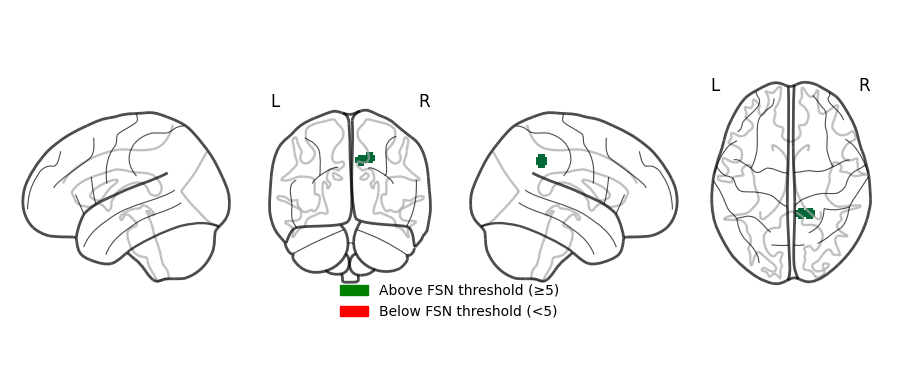

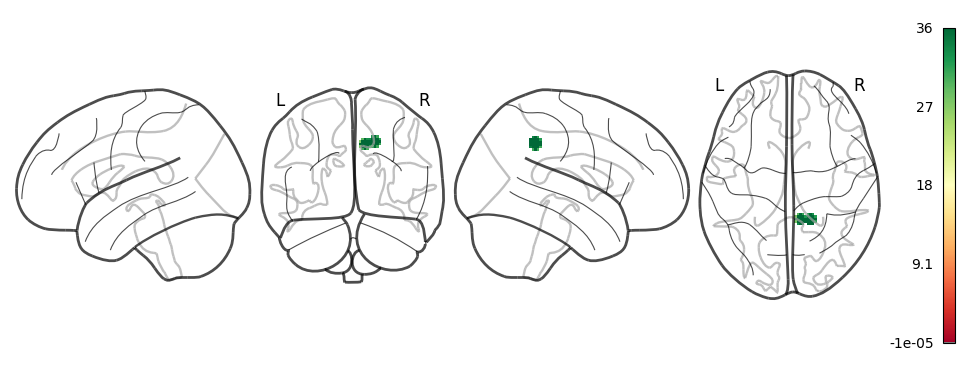

In [9]:
from nilearn import plotting
import matplotlib.patches as mpatches

PREFIX = "hyperactivation"  # 根据你的分析调整
OUTPUT_ROOT = "/Volumes/ss/Self_Psych_Meta/3_Output/7_FSN"

# FSN 绘图（需先运行完上面的聚合 cell，生成 mean_fsn.nii.gz）
base_dir = path.join(OUTPUT_ROOT, PREFIX)

# 加载 mean FSN 图（体素级 FSN 值）
img_fsn = image.load_img(path.join(base_dir, PREFIX + "_mean_fsn.nii.gz"))
data = img_fsn.get_fdata()

# 阈值：FSN 低于此值视为「不稳健」。常用 30% × 原始研究数
n_studies = 17  # 根据你的 hyper_and_hypo 研究数调整
fsn_threshold = max(1, 0.3 * n_studies)  # 至少为 1

# 分割为 below（红）和 above（绿）mask
img_below = image.new_img_like(img_fsn, ((data > 0) & (data < fsn_threshold)).astype(float))
img_above = image.new_img_like(img_fsn, (data >= fsn_threshold).astype(float))

# Glass brain 叠加
fsn_plot = plotting.plot_glass_brain(None, display_mode="lyrz")
fsn_plot.add_overlay(img_below, cmap="OrRd", vmin=0, vmax=1, colorbar=False)
fsn_plot.add_overlay(img_above, cmap="RdYlGn", vmin=0, vmax=1, colorbar=False)

green_patch = mpatches.Patch(color="green", label="Above FSN threshold (≥{:.0f})".format(fsn_threshold))
red_patch = mpatches.Patch(color="red", label="Below FSN threshold (<{:.0f})".format(fsn_threshold))
plt.legend(handles=[green_patch, red_patch], loc="lower center", frameon=False, bbox_to_anchor=(-1.2, -0.08), borderaxespad=0.)
plt.show()

# 可选：直接显示 FSN 数值的 glass brain（连续色阶）
plotting.plot_glass_brain(img_fsn, display_mode="lyrz", colorbar=True, cmap="RdYlGn", vmin=0, vmax=max(1, data.max()))